In [1]:
%matplotlib inline

# This notebook is a demonstration of how to use Dipy's registration tools

(based on tutorials, below)

http://nipy.org/dipy/examples_built/affine_registration_3d.html

http://nipy.org/dipy/examples_built/syn_registration_3d.html#example-syn-registration-3d

This example registers multiple timepoints of a single subject. We are registering the fractional anisotropy image in one timepoint to the other timepoint. At the end, we use the calculated transform to move the masks between the spaces. NOTE: since this is a single subject without pathology, we do not need to perform an affine or diffeomorphic registration (a rigid should suffice). For this demonstration, however, all of the transforms are calculated.

- Single subject longitudinal (no pathology expected) = up to rigid
- Single subject longitudinal (pathology expected) = rigid and diffeomorphic (skip affine)
- Single subject longitudinal without susceptibility correction = rigid and diffeomorphi
- Between subjects = run the whole notebook

*Don't forget to Quality Control!*

In [2]:
import numpy as np
import dipy.align.imwarp as imwarp
from dipy.viz import regtools
from dipy.align.imaffine import (transform_centers_of_mass, AffineMap, MutualInformationMetric, AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D, RigidTransform3D, AffineTransform3D)
from nipype.utils.filemanip import load_json
import os
from glob import glob
import nibabel as nib
import scipy.io as sio

from IPython.display import Image
import matplotlib.pyplot as plt

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Functions

Load and save niftis

In [3]:
def loadnii(path):
    im = nib.load(path)
    aff = im.affine
    data = im.get_data()
    return data, aff

In [4]:
def savenii(data, aff, path):
    img = nib.Nifti1Image(data, aff)
    img.get_data_dtype() == np.dtype(np.int16)
    img.set_qform(aff, 1)
    img.set_sform(aff, 1)
    img.to_filename(path)

Display a registration quality (Red static, Green moving)

In [5]:
def showme_savepng(static_im, moving_resampled_im, savebasename):
    regtools.overlay_slices(static_im, moving_resampled_im, None, 0, "Static", "Moving", savebasename+"_0.png")
    regtools.overlay_slices(static_im, moving_resampled_im, None, 1, "Static", "Moving", savebasename+"_1.png")
    regtools.overlay_slices(static_im, moving_resampled_im, None, 2, "Static", "Moving", savebasename+"_2.png")

In [6]:
def showme(static_im, moving_resampled_im, savebasename):
    regtools.overlay_slices(static_im, moving_resampled_im, None, 0, "Static", "Moving")
    regtools.overlay_slices(static_im, moving_resampled_im, None, 1, "Static", "Moving")
    regtools.overlay_slices(static_im, moving_resampled_im, None, 2, "Static", "Moving")

# EDIT THIS FOR EACH SUBJECT

In [7]:
from nilearn.plotting import plot_anat

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Figure out paths to images

In [8]:
im1 = '/Users/kesshijordan/ref_data/interscan_dys/Prisma/IC004-4_dti_b2500_SC_EC_fa.nii.gz'
im2 = '/Users/kesshijordan/ref_data/interscan_dys/Trio/IC004-1_dti_b2000_EC_fa.nii.gz'

In [9]:
## Set the directory you want the outputs saved in
putdir = 'output_example_registration'

if not os.path.exists(putdir):
    os.mkdir(putdir)

## Plot the two images you want to register

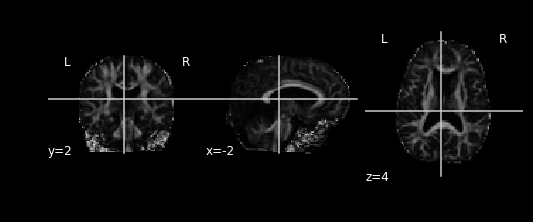

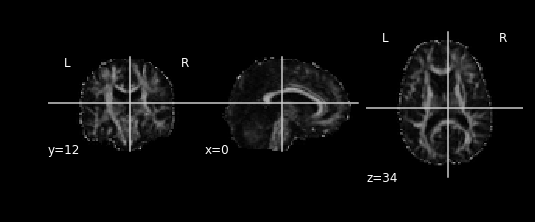

In [10]:
plot_anat(im1)
plot_anat(im2)

In [11]:
static_path = im1
moving_path = im2

static, static_grid2world = loadnii(static_path)
moving, moving_grid2world = loadnii(moving_path)

print(static.shape)
print(moving.shape)

(110, 110, 69)
(100, 100, 60)


# Register The Moving to Static Image

## Show alignment with no transform

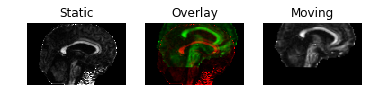

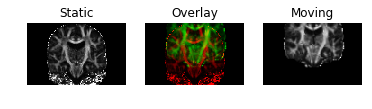

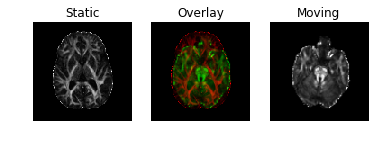

In [12]:
identity = np.eye(4)
affine_map = AffineMap(identity, static.shape, static_grid2world, moving.shape, moving_grid2world)
resampled = affine_map.transform(moving)
showme(static, resampled, 'noxfm')
#plt.close('all')

## Align the centers of mass

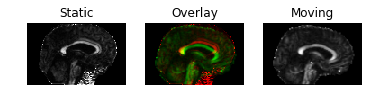

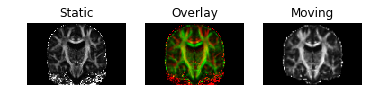

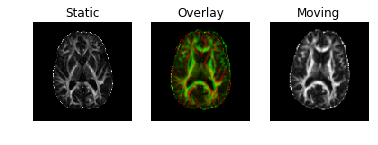

In [13]:
c_of_mass = transform_centers_of_mass(static, static_grid2world, moving, moving_grid2world)
transformed_com = c_of_mass.transform(moving)
showme(static, transformed_com, 'step1_com')

## Translation

Optimizing level 2 [max iter: 100000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


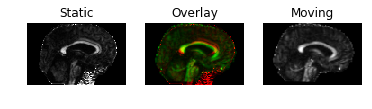

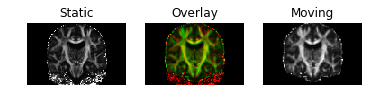

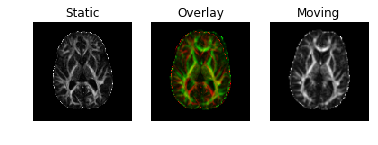

In [14]:
nbins=32
sampling_prop=None
metric=MutualInformationMetric(nbins, sampling_prop)
level_iters = [100000, 1000, 100]
sigmas = [3.0, 1.0, 0.0]
factors = [4,2,1]
affreg = AffineRegistration(metric=metric, level_iters=level_iters, sigmas=sigmas, factors=factors)

transform=TranslationTransform3D()
params0=None
starting_affine = c_of_mass.affine
translation = affreg.optimize(static, moving, transform, params0, static_grid2world, moving_grid2world, starting_affine=starting_affine)
transformed_trans = translation.transform(moving)
showme(static, transformed_trans, 'step2_trans')

## Rigid

Optimizing level 2 [max iter: 100000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


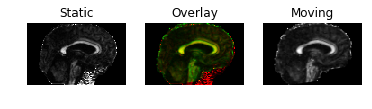

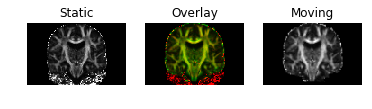

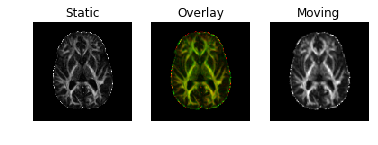

In [15]:
transform = RigidTransform3D()
params0 = None
starting_affine = translation.affine
rigid = affreg.optimize(static, moving, transform, params0,
                        static_grid2world, moving_grid2world,
                        starting_affine=starting_affine)

transformed_rigid = rigid.transform(moving)
showme(static, transformed_rigid,'step3_rigid')

In [16]:
#Save a copy of the static image in the output directory
savenii(static, static_grid2world, os.path.join(putdir,'static.nii.gz'))
#Save the rigidly transformed moving image in the static space
savenii(transformed_rigid, static_grid2world, os.path.join(putdir,'moving_rigid.nii.gz'))

## Affine

Optimizing level 2 [max iter: 100000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


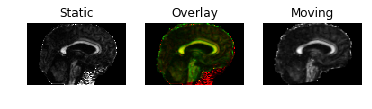

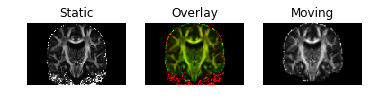

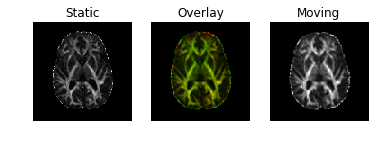

In [17]:
transform = AffineTransform3D()
params0 = None
starting_affine = rigid.affine
affine = affreg.optimize(static, moving, transform, params0,
                         static_grid2world, moving_grid2world,
                         starting_affine=starting_affine)

transformed_affine = affine.transform(moving)
showme(static, transformed_affine, 'step4_affine')
savenii(transformed_affine, static_grid2world, os.path.join(putdir,'moving_affine.nii.gz'))

## Diffeomorphic (Nonlinear) Registration

In [18]:
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.imwarp import DiffeomorphicMap
from dipy.align.metrics import CCMetric

In [19]:
metric=CCMetric(3)
pre_align = rigid.affine
level_iters = [10, 10, 5]
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters)

In [20]:
warp = sdr.optimize(static, moving, static_grid2world, moving_grid2world, pre_align)

Creating scale space from the moving image. Levels: 3. Sigma factor: 0.200000.
Creating scale space from the static image. Levels: 3. Sigma factor: 0.200000.
Optimizing level 2
Optimizing level 1
Optimizing level 0


### Forward transform (moving to static space)

In [21]:
warped_moving = warp.transform(moving)

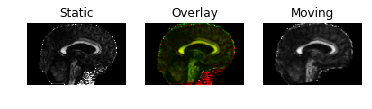

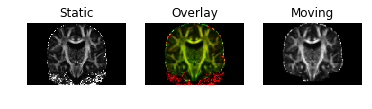

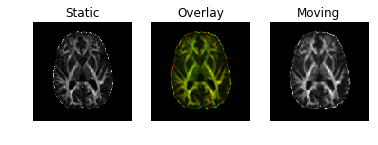

In [22]:
showme(static, warped_moving, 'step5_warp')
savenii(warped_moving, static_grid2world, os.path.join(putdir,'warped.nii.gz'))

### Inverse transform (static to moving space)

We calculated the warp from the moving to the static space, but now we apply the inverse transform to move something from the static space to the moving.

In [23]:
warped_static = warp.transform_inverse(static)

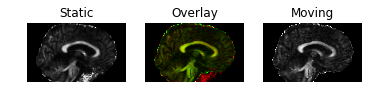

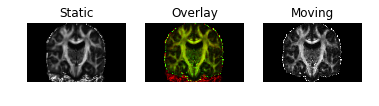

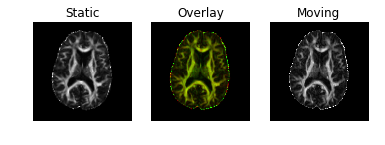

In [24]:
showme(warped_static, moving, 'step5_INVERSE_warp')

# Apply these transforms to new images 

Now we will transform the masks from the diffusion scan (same space, different image). You can use the same process to transform any volumetric data (other images/masks/ROIs, etc) from one space to the other. As we can see here, one of the masks (static) contains some noise, so you can see how the warped masks still match the original image, but have been transferred to the opposite space.

In [25]:
#STATIC
extra_image_static = '/Users/kesshijordan/ref_data/interscan_dys/Prisma/IC004-4_dti_b2500_SC_EC_mask.nii.gz'
#MOVING
extra_image_moving = '/Users/kesshijordan/ref_data/interscan_dys/Trio/IC004-1_dti_b2000_EC_mask.nii.gz'

exim_static, aff = loadnii(extra_image_static)
exim_moving, aff = loadnii(extra_image_moving)

## Forward transform (moving to static)

In [26]:
#this will put extra_image_moving in the static space
exim_moving_in_static = warp.transform(exim_moving)

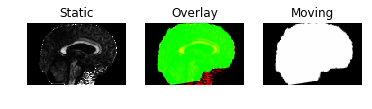

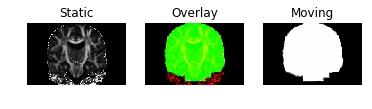

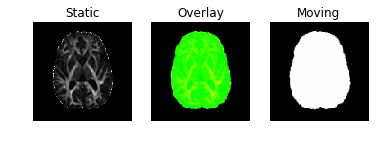

In [27]:
showme(static,exim_moving_in_static, 'extra_warped2static')

In [28]:
#this will put extra_image_static in the moving space using the inverse warp
exim_static_in_moving = warp.transform_inverse(exim_static)

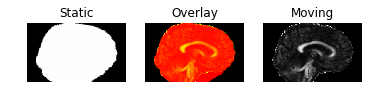

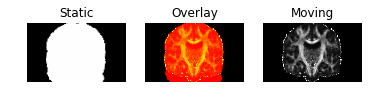

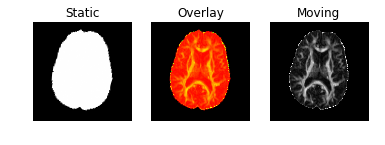

In [29]:
showme(exim_static_in_moving,moving, 'extra_warped2static')